In [0]:
import json
import requests
import urllib

# 0. Preliminary step to get sample data



This preliminary step is reproducing Lorella's workflow Python file:
https://i-lab.public.data.uu.nl/vault-ocex/ChroniclItaly%20-%20Italian%20American%20newspapers%20corpus%20from%201898%20to%201920%5B1529330521%5D/original/
I just added a folder "data_1" to keep all files in one folder

In [0]:
mkdir 'data1'

In [0]:
# Base URL
chronam = 'https://chroniclingamerica.loc.gov/'

# Chronicling America search results
results = 'https://chroniclingamerica.loc.gov/search/pages/results/?date1=1880&date2=1920&searchType=advanced&language=ita&sequence=1&lccn=2012271201&lccn=sn85066408&lccn=sn85055164&lccn=sn85054967&lccn=sn88064299&lccn=sn84037024&lccn=sn84037025&lccn=sn86092310&proxdistance=5&state=California&state=District+of+Columbia&state=Massachusetts&state=Pennsylvania&state=Piedmont&state=Vermont&state=West+Virginia&rows=100&ortext=&proxtext=&phrasetext=&andtext=&dateFilterType=yearRange&page=11&sort=date'

# Count to keep track of downloaded files
count = 0

# Gets search results in JSON format
results_json = results + '&format=json'


In [0]:
# Returns JSON 
def get_json(url):
    data = requests.get(url)
    return(json.loads(data.content))
    
data = get_json(results_json)

In [0]:
files_list = []
# Cycle through JSON results
for page in data['items']:
    # Create URL
    hit = str(page['id'])
    seed = hit + 'ocr.txt'
    download_url = chronam + seed
 
    # Create file name
    file_name = download_url.replace('/', '_')
    files_list.append(file_name[41:])
    file_name = 'data1/' + file_name[41:]

    # Download .txt of the page
    urllib.request.urlretrieve(download_url, str(file_name))
    count += 1

# 1. Data preparation

## 1.1. Creating data frame
A dataframe is first created to keep the documents at their initial state, and the name of each file

In [0]:
import os
import pandas as pd

In [0]:
#insert file names into a df
sources = pd.DataFrame(files_list, columns=['file_name'])

In [0]:
#function to read the content of the text files
def readTxtContent(fileName):
  with open('data1/' + fileName, 'r') as file:
    return ' ' + file.read().replace('\n', ' ') + ' '

In [0]:
# adding a column to the dataframe containing file content
sources['file_content'] = sources['file_name'].apply(lambda x: readTxtContent(x))

In [0]:
# variable containing the documents separately
corpus = sources['file_content']

In [0]:
# the 2 cells below shouldn't be useful anymore
# for verification purposes later, count the nr of characters for each content
#sources['file_len'] = sources['file_content'].apply(lambda x: len(x))
#sources['file_len'].sum()

In [0]:

# variable containing all documents together
#all_texts = ''
#for i in range(len(sources)):
#all_texts += sources['file_content'][i]
# check length
#len(all_texts)

## 1.2 Removing stop words, punctuation, short words

In [0]:
%%capture
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [0]:
# add tokenized documents in dataframe
sources['tokens'] = sources['file_content'].apply(lambda x: nltk.word_tokenize(x))

In [0]:
# possible user options:
# .isalnum() to removes tokens that include numbers
# .isalpha() to removes all tokens that contain more than letters (punctuation and numbers)
# .isdecimal() to remove tokens that contain only decimals
# .isdigit() to remove tokens that contain only digits

# add new column in df with processed tokens (here: keeping only alpha tokens longer than 3 characters + lowercasing)
sources['doc_prep'] = sources['tokens'].apply(lambda x: [w.lower() for w in x if (w.isalpha() and len(w) > 3 )])

In [0]:
from nltk.corpus import stopwords
ital_stopwords = stopwords.words('italian')

In [0]:
# to append list of words added by user: ital_stopwords.extend(user_input)
# to remove words: ital_stopwords.remove(user_input)

In [0]:
# spacy list of Stop words (seems to be more complete than NLTK)
# import spacy
# from spacy.lang.it.stop_words import STOP_WORDS
# spacy_it_sw = STOP_WORDS

In [0]:
# add column with tokenized documents without sw
sources['doc_prep_nostop'] = sources['doc_prep'].apply(lambda x: [w for w in x if not w in ital_stopwords])

## 1.3 Stem

In [0]:
from nltk.stem.snowball import SnowballStemmer

In [0]:
#initialize with needed language
stemmer = SnowballStemmer("italian")

In [0]:
# add column with stemmed tokens
sources['doc_stemmed'] = sources['doc_prep_nostop'].apply(lambda x: [stemmer.stem(w) for w in x])

## 1.4 Lemmatize

In [0]:
# Lemmatization is available in multiple languages in Spacy and not in NLTK (only English)
# With Spacy, lemmatization is available for 10 languages. There's also a multi-language option that
# should be tested if additional languages are needed

In [0]:
%%capture
!python -m spacy download it_core_news_sm

In [0]:
import it_core_news_sm
it_nlp = it_core_news_sm.load(disable=['tagger', 'parser', 'ner'])

In [0]:
# lemmatization function
def lemmatize(doc):
  lemmatized_doc = []
  for w in doc:
    w_lemma = [token.lemma_ for token in it_nlp(w)]
    lemmatized_doc.append(w_lemma[0])
  return lemmatized_doc

In [0]:
# add column with lemmatized tokens
sources['doc_lemmatized'] = sources['doc_prep_nostop'].apply(lambda x: lemmatize(x))

In [0]:
# variable with lemmatized tokens
lemmatized_corpus = sources['doc_lemmatized']

# 2. Topics with LDA

In [0]:
%%capture
# installation setup that works for Mallet: https://github.com/polsci/colab-gensim-mallet/blob/master/topic-modeling-with-colab-gensim-mallet.ipynb
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

In [0]:
%%capture
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [0]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [0]:
#Gensim installation
import gensim
from gensim.test.utils import common_corpus, common_dictionary
from gensim import corpora, models
from gensim.models.wrappers import LdaMallet

## 2.1 Preliminary steps to run LDA



### 2.1.1 Bag of words

In [0]:
# dataset = [d.split() for d in lemmatized_corpus] (this is not useful if lemmatized version is used)
# Create Dictionary
# change "lemmatized_corpus" variable by stemmed_corpus or tokenized_corpus_without_sw depending
# on which version you would like to work with 
id2word = corpora.Dictionary(lemmatized_corpus)
corpus = [id2word.doc2bow(text) for text in lemmatized_corpus]

In [0]:
# list of words and occurence per document
words = []
frequency = []

for cp in corpus:
  word_id = list(cp[0])[0]
  words.append(id2word[list(cp[0])[0]])
  frequency.append(list(cp[0])[1])

In [0]:
words_frequency = pd.DataFrame(list(zip(words, frequency)), columns=['word', 'frequency'])

In [0]:
# sort descending
# words_frequency.sort_values(by=['frequency'], ascending=False)[:10]

## 2.2 LDA

In [0]:
# set the number of topics here
numtopics = 6

### 2.2.1 LDA with Gensim

In [0]:
ldagensim = models.LdaModel(corpus, id2word=id2word, num_topics=numtopics)

In [32]:
ldagensim.print_topics()

[(0,
  '0.005*"italiano" + 0.004*"stare" + 0.004*"dispaccio" + 0.004*"roma" + 0.004*"telegrafico" + 0.004*"fare" + 0.003*"nuovo" + 0.003*"dire" + 0.003*"anno" + 0.003*"italia"'),
 (1,
  '0.007*"italiano" + 0.005*"italia" + 0.004*"altro" + 0.004*"stare" + 0.004*"anno" + 0.003*"dire" + 0.003*"fare" + 0.003*"dispaccio" + 0.003*"roma" + 0.003*"primo"'),
 (2,
  '0.005*"italiano" + 0.003*"stare" + 0.003*"giornale" + 0.003*"fare" + 0.003*"dire" + 0.003*"tutto" + 0.003*"nuovo" + 0.003*"italia" + 0.003*"roma" + 0.002*"grande"'),
 (3,
  '0.007*"italiano" + 0.004*"anno" + 0.004*"stare" + 0.004*"fare" + 0.003*"italia" + 0.003*"potere" + 0.003*"nuovo" + 0.003*"dispaccio" + 0.003*"partire" + 0.003*"altro"'),
 (4,
  '0.008*"italiano" + 0.004*"stare" + 0.004*"roma" + 0.004*"fare" + 0.004*"dispaccio" + 0.003*"venire" + 0.003*"potere" + 0.003*"primo" + 0.003*"italia" + 0.003*"altro"'),
 (5,
  '0.008*"italiano" + 0.004*"potere" + 0.004*"italia" + 0.004*"stare" + 0.003*"altro" + 0.003*"grande" + 0.003*"te

### 2.2.2 Visualize topics

In [0]:
# pyLDAvis installation
%%capture
! pip install pyldavis
import pyLDAvis
import pyLDAvis.gensim

In [0]:
# insert the model and number of topics you want to visualise
# here LDA Gensim with 6 topics
%%capture
numtopics = 6
selected_model = models.LdaModel(corpus, id2word=id2word, num_topics=numtopics)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(selected_model, corpus, id2word)

In [35]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.003844  0.003106       1        1  42.105400
1     -0.004402 -0.003267       2        1  29.580677
4      0.001526 -0.001133       3        1  11.598258
2      0.001099  0.002568       4        1   9.264569
0      0.001512 -0.000654       5        1   5.968758
5      0.004110 -0.000619       6        1   1.482341, topic_info=           Term         Freq        Total Category  logprob  loglift
473    italiano  1047.000000  1047.000000  Default  30.0000  30.0000
348        fare   430.000000   430.000000  Default  29.0000  29.0000
280   dispaccio   469.000000   469.000000  Default  28.0000  28.0000
36        altro   421.000000   421.000000  Default  27.0000  27.0000
471      italia   494.000000   494.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
944       stare     5.445202   611.857422   Topic6  -5.9817  -0.5102
719      potere     4.746392   470.734344   Topic6  -6.1191  -0.3854
578       molto     4.127904   343.960358   Topic6  -6.2587  -0.2112
670     partire     3.668861   328.934357   Topic6  -6.3766  -0.2844
1056     venire     3.737642   414.037506   Topic6  -6.3580  -0.4960

[550 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
14833      1  0.481439  abitudine
14833      2  0.481439  abitudine
15530      1  0.696843     acorse
15530      2  0.348421     acorse
13         1  0.586528      acqua
...      ...       ...        ...
4592       1  0.542862      zlone
4592       2  0.180954      zlone
4592       3  0.090477      zlone
4592       4  0.090477      zlone
22334      1  0.709403     ìntime

[1379 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 5, 3, 1, 6])

### 2.2.3 LDA with Mallet

In [0]:
%%capture
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=numtopics, id2word=id2word)

In [37]:
ldamallet.print_topics()

[(0,
  '0.027*"italiano" + 0.012*"roma" + 0.011*"fare" + 0.011*"italia" + 0.009*"grande" + 0.009*"dispaccio" + 0.008*"stato" + 0.008*"telegrafico" + 0.008*"giornale" + 0.007*"altro"'),
 (1,
  '0.010*"giorno" + 0.008*"città" + 0.008*"primo" + 0.007*"presidente" + 0.007*"maggio" + 0.006*"vivo" + 0.006*"italia" + 0.005*"quotidiano" + 0.005*"generale" + 0.005*"tutto"'),
 (2,
  '0.011*"dispaccio" + 0.009*"nuovo" + 0.009*"telegrafico" + 0.007*"dopo" + 0.007*"italiano" + 0.006*"notizia" + 0.006*"dire" + 0.006*"durare" + 0.006*"ieri" + 0.005*"ministrare"'),
 (3,
  '0.008*"sotto" + 0.007*"ogni" + 0.007*"potere" + 0.007*"sempre" + 0.006*"lottare" + 0.006*"tutto" + 0.006*"cosa" + 0.005*"menare" + 0.005*"vita" + 0.005*"stare"'),
 (4,
  '0.016*"cardinale" + 0.013*"papa" + 0.009*"roma" + 0.008*"italiano" + 0.008*"nuovo" + 0.007*"venire" + 0.007*"chiesa" + 0.006*"pontefice" + 0.006*"vaticano" + 0.006*"dopo"'),
 (5,
  '0.015*"stare" + 0.013*"potere" + 0.012*"altro" + 0.012*"anno" + 0.010*"partire" + 0

## 2.3 Topic Coherence
Topic Coherence measures score of a single topic by measuring the degree of semantic similarity between high scoring words in the topic. https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [0]:
from gensim.models.coherencemodel import CoherenceModel

### 2.3.1 Coherence score LDA Gensim

In [39]:
coherence_model_ldagensim = CoherenceModel(model=ldagensim, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
coherence_ldagensim = coherence_model_ldagensim.get_coherence()
print('\nCoherence Score LDA Gensim: ', coherence_ldagensim)


Coherence Score LDA Gensim:  0.2499700822790589


### 2.3.1 Coherence score LDA Mallet


In [40]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score LDA MAllet: ', coherence_ldamallet)


Coherence Score LDA MAllet:  0.33507288362015686


## 2.4 Coherence and number of topics

### 2.4.1 LDA Gensim

In [0]:
#can take a long time to run
%%capture
topics_nr = []
coherence_values_gensim = []
for num_topics in range(2, 20):
  model = models.LdaModel(corpus, id2word=id2word, num_topics=num_topics)
  coherencemodel = CoherenceModel(model=model, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
  coherence_value = coherencemodel.get_coherence()
  coherence_values_gensim.append(coherence_value)
  topics_nr.append(str(num_topics))

In [0]:
for i in range(len(topics_nr)):
  print("Num Topics =", topics_nr[i], " has Coherence Value of", round(coherence_values_gensim[i],4))

Num Topics = 2  has Coherence Value of 0.2514
Num Topics = 3  has Coherence Value of 0.2504
Num Topics = 4  has Coherence Value of 0.2506
Num Topics = 5  has Coherence Value of 0.2555
Num Topics = 6  has Coherence Value of 0.2486
Num Topics = 7  has Coherence Value of 0.2546
Num Topics = 8  has Coherence Value of 0.2551
Num Topics = 9  has Coherence Value of 0.2579
Num Topics = 10  has Coherence Value of 0.2515
Num Topics = 11  has Coherence Value of 0.2581
Num Topics = 12  has Coherence Value of 0.2568
Num Topics = 13  has Coherence Value of 0.2559
Num Topics = 14  has Coherence Value of 0.2559
Num Topics = 15  has Coherence Value of 0.2558
Num Topics = 16  has Coherence Value of 0.2502
Num Topics = 17  has Coherence Value of 0.2568
Num Topics = 18  has Coherence Value of 0.2548
Num Topics = 19  has Coherence Value of 0.2549


In [0]:
# Visualize coherence scores
import matplotlib.pyplot as plt

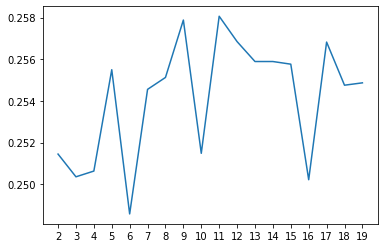

In [0]:
plt.plot(topics_nr, coherence_values_gensim)

In [0]:
# To analyse the results, the user can print the list of topics for different topic nr

In [0]:
# print topics for nr of topics = 7
%%capture
numtopics = 7
model = models.LdaModel(corpus, id2word=id2word, num_topics=numtopics)

In [0]:
model.print_topics()

[(0,
  '0.006*"italiano" + 0.005*"stare" + 0.004*"fare" + 0.003*"anno" + 0.003*"dispaccio" + 0.003*"altro" + 0.003*"potere" + 0.003*"telegrafico" + 0.003*"tutto" + 0.003*"dire"'),
 (1,
  '0.008*"italiano" + 0.004*"stare" + 0.004*"italia" + 0.004*"roma" + 0.004*"altro" + 0.003*"anno" + 0.003*"fare" + 0.003*"primo" + 0.003*"cardinale" + 0.003*"grande"'),
 (2,
  '0.006*"italiano" + 0.004*"italia" + 0.003*"roma" + 0.003*"stare" + 0.003*"anno" + 0.003*"dire" + 0.003*"nuovo" + 0.003*"cardinale" + 0.003*"primo" + 0.003*"altro"'),
 (3,
  '0.008*"italiano" + 0.005*"potere" + 0.004*"dispaccio" + 0.004*"roma" + 0.003*"nuovo" + 0.003*"telegrafico" + 0.003*"italia" + 0.003*"stare" + 0.003*"fare" + 0.003*"dire"'),
 (4,
  '0.007*"italiano" + 0.004*"stare" + 0.004*"roma" + 0.003*"italia" + 0.003*"telegrafico" + 0.003*"dire" + 0.003*"primo" + 0.003*"altro" + 0.003*"dispaccio" + 0.003*"potere"'),
 (5,
  '0.007*"italiano" + 0.005*"stare" + 0.004*"fare" + 0.003*"italia" + 0.003*"dispaccio" + 0.003*"altro"

### 2.4.2 LDA Mallet

In [0]:
#can take a long time to run
%%capture
topics_nr = []
coherence_values_mallet = []
for num_topics in range(2, 20):
  model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
  coherencemodel = CoherenceModel(model=model, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
  coherence_value = coherencemodel.get_coherence()
  coherence_values_mallet.append(coherence_value)
  topics_nr.append(str(num_topics))

In [0]:
for i in range(len(topics_nr)):
  print("Num Topics =", topics_nr[i], " has Coherence Value of", round(coherence_values_mallet[i],4))

Num Topics = 2  has Coherence Value of 0.3059
Num Topics = 3  has Coherence Value of 0.3064
Num Topics = 4  has Coherence Value of 0.3378
Num Topics = 5  has Coherence Value of 0.3154
Num Topics = 6  has Coherence Value of 0.3434
Num Topics = 7  has Coherence Value of 0.3439
Num Topics = 8  has Coherence Value of 0.3477
Num Topics = 9  has Coherence Value of 0.3416
Num Topics = 10  has Coherence Value of 0.3486
Num Topics = 11  has Coherence Value of 0.3633
Num Topics = 12  has Coherence Value of 0.3801
Num Topics = 13  has Coherence Value of 0.3429
Num Topics = 14  has Coherence Value of 0.3448
Num Topics = 15  has Coherence Value of 0.3582
Num Topics = 16  has Coherence Value of 0.3564
Num Topics = 17  has Coherence Value of 0.369
Num Topics = 18  has Coherence Value of 0.3408
Num Topics = 19  has Coherence Value of 0.3605


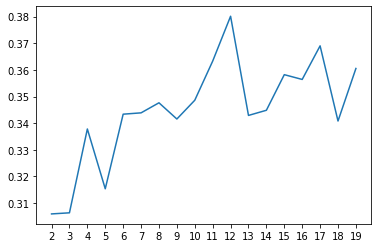

In [0]:
plt.plot(topics_nr, coherence_values_mallet)

In [0]:
# To analyse the results, the user can print the list of topics for different topic nr

In [0]:
# print topics for nr of topics = 8
%%capture
numtopics = 8
model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=numtopics, id2word=id2word)

In [0]:
model.print_topics()

[(0,
  '0.010*"potere" + 0.009*"leggere" + 0.008*"tutto" + 0.007*"stare" + 0.007*"lavorare" + 0.007*"cosa" + 0.007*"sotto" + 0.006*"senza" + 0.006*"lottare" + 0.006*"ogni"'),
 (1,
  '0.014*"roma" + 0.010*"presidente" + 0.009*"fare" + 0.008*"tutto" + 0.008*"dovere" + 0.007*"perchè" + 0.007*"persona" + 0.007*"parigi" + 0.006*"governare" + 0.006*"andare"'),
 (2,
  '0.018*"italiano" + 0.013*"primo" + 0.012*"anno" + 0.011*"città" + 0.010*"italia" + 0.009*"grande" + 0.009*"maggio" + 0.009*"dispaccio" + 0.009*"solere" + 0.008*"daily"'),
 (3,
  '0.011*"dire" + 0.010*"italiano" + 0.010*"altro" + 0.010*"fare" + 0.009*"stare" + 0.009*"egli" + 0.008*"generale" + 0.008*"venire" + 0.008*"roma" + 0.008*"dopo"'),
 (4,
  '0.014*"dispaccio" + 0.013*"telegrafico" + 0.012*"italiano" + 0.012*"americano" + 0.011*"giornale" + 0.010*"stato" + 0.009*"daily" + 0.008*"italia" + 0.007*"partire" + 0.006*"giorno"'),
 (5,
  '0.012*"nuovo" + 0.008*"governare" + 0.007*"ministrare" + 0.007*"dispaccio" + 0.007*"regina" 

# Topic distribution

## 3.1. Gensim

### 3.1.1. Distribution per topic and per document

In [0]:
%%capture
numtopics = 8
ldamodel = models.LdaModel(corpus, num_topics=numtopics, id2word = id2word, minimum_probability=0)

In [0]:
doc_topic_weights = ldamodel.inference(corpus)[0]
doc_topic_dists = doc_topic_weights / doc_topic_weights.sum(axis=1)[:, None]

In [0]:
distribution_gensim = pd.DataFrame(doc_topic_dists,columns=[f'topic{i}' for i in range(numtopics)])

In [0]:
distribution_gensim.index.name = 'document'

In [107]:
# add file names
distribution_gensim_wfiles = distribution_gensim.copy()
distribution_gensim_wfiles.insert(0, 'document_path', sources['file_name'])
distribution_gensim_wfiles

,document_path,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7
document,,,,,,,,,
0,sn85066408_1903-04-27_ed-1_seq-1_ocr.txt,0.012130,0.000080,0.000078,0.000078,0.815193,0.009959,0.000078,0.162403
1,sn85066408_1903-04-28_ed-1_seq-1_ocr.txt,0.000070,0.999512,0.000070,0.000070,0.000070,0.000070,0.000070,0.000070
2,sn85066408_1903-04-29_ed-1_seq-1_ocr.txt,0.000093,0.000093,0.000138,0.000093,0.744084,0.000093,0.000093,0.255315
3,sn85066408_1903-04-30_ed-1_seq-1_ocr.txt,0.002381,0.742540,0.000100,0.000100,0.254579,0.000100,0.000100,0.000100
4,sn85066408_1903-05-01_ed-1_seq-1_ocr.txt,0.000150,0.009218,0.030425,0.000150,0.945476,0.005410,0.009020,0.000150
...,...,...,...,...,...,...,...,...,...
95,sn85066408_1903-08-05_ed-1_seq-1_ocr.txt,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.997976,0.000289
96,sn85066408_1903-08-06_ed-1_seq-1_ocr.txt,0.000565,0.000086,0.000086,0.000086,0.074049,0.000086,0.924957,0.000086
97,sn85066408_1903-08-07_ed-1_seq-1_ocr.txt,0.000076,0.000076,0.086413,0.000076,0.027437,0.885768,0.000076,0.000076


### 3.1.2. Distribution per topic for the whole corpus

In [0]:
sources['doc_length'] = sources['doc_lemmatized'].apply(lambda x: len(x))

In [0]:
topic_frequency = distribution_gensim.mul(sources['doc_length'], axis=0).sum()

In [0]:
topic_proportion = (topic_frequency / topic_frequency.sum()*100).sort_values(ascending=False)

In [137]:
topic_proportion

topic5    25.364300
topic4    19.694167
topic1    12.992584
topic7    11.728509
topic6    10.303622
topic2     9.988825
topic0     7.282110
topic3     2.645883
dtype: float64

In [0]:
# dataframe with values to sort them by order of importance
distribution_df_gensim = pd.DataFrame(topic_proportion, columns=['weight'])

In [140]:
distribution_df_gensim

,weight
topic5,25.364300
topic4,19.694167
topic1,12.992584
topic7,11.728509
topic6,10.303622
topic2,9.988825
topic0,7.282110
topic3,2.645883


In [0]:
distribution_df_gensim.index.name = "topics"

In [0]:
topics = distribution_df_gensim.index.array

Text(0.5, 0, 'Weight (%)')

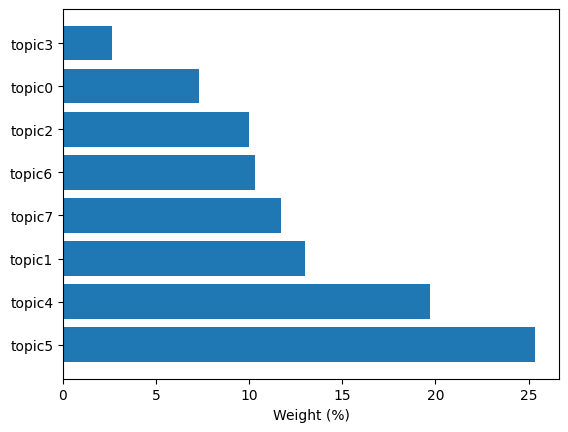

In [150]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(topics, distribution_df_gensim['weight'], align='center')
ax.set_xlabel('Weight (%)')

##3.2 Mallet

### 3.2.1 Distribution per topic and per document

In [0]:
%%capture
#create variable to retranslate model to Gensim, to be able to compute distribution at a later stage
numtopics = 8
ldamodel = models.LdaModel(corpus, num_topics=numtopics, id2word = id2word, minimum_probability=0)
ldamallet = model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=numtopics, id2word=id2word)
ldamallet_to_gensim = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [0]:
doc_topic_weights_mallet = ldamallet_to_gensim.inference(corpus)[0]

In [0]:
doc_topic_dists_mallet = doc_topic_weights_mallet / doc_topic_weights_mallet.sum(axis=1)[:, None]

In [0]:
distribution_mallet = pd.DataFrame(doc_topic_dists_mallet,columns=[f'topic{i}' for i in range(numtopics)])

In [0]:
distribution_mallet.index.name = 'document'

In [159]:
# add file names
distribution_mallet_wfiles = distribution_mallet.copy()
distribution_mallet_wfiles.insert(0, 'document_path', sources['file_name'])
distribution_mallet_wfiles

,document_path,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7
document,,,,,,,,,
0,sn85066408_1903-04-27_ed-1_seq-1_ocr.txt,0.200439,0.094910,0.056177,0.060327,0.046570,0.131359,0.275242,0.134974
1,sn85066408_1903-04-28_ed-1_seq-1_ocr.txt,0.157147,0.103820,0.049159,0.049260,0.032337,0.168134,0.151856,0.288288
2,sn85066408_1903-04-29_ed-1_seq-1_ocr.txt,0.235506,0.074993,0.160834,0.034456,0.037809,0.066163,0.275204,0.115037
3,sn85066408_1903-04-30_ed-1_seq-1_ocr.txt,0.129978,0.091381,0.076096,0.044044,0.041132,0.130995,0.384672,0.101701
4,sn85066408_1903-05-01_ed-1_seq-1_ocr.txt,0.595012,0.014316,0.044717,0.139986,0.019309,0.068236,0.083716,0.034708
...,...,...,...,...,...,...,...,...,...
95,sn85066408_1903-08-05_ed-1_seq-1_ocr.txt,0.159379,0.041782,0.067414,0.027833,0.408906,0.135216,0.127481,0.031989
96,sn85066408_1903-08-06_ed-1_seq-1_ocr.txt,0.102871,0.066299,0.062895,0.053027,0.205600,0.118500,0.075974,0.314834
97,sn85066408_1903-08-07_ed-1_seq-1_ocr.txt,0.142841,0.028958,0.131414,0.067796,0.211199,0.159214,0.098523,0.160054


### 3.2.2. Distribution per topic for the whole corpus

In [0]:
topic_frequency_mallet = distribution_mallet.mul(sources['doc_length'], axis=0).sum()

In [0]:
topic_proportion_mallet = (topic_frequency_mallet / topic_frequency_mallet.sum()*100).sort_values(ascending=False)

In [0]:
distribution_df_mallet = pd.DataFrame(topic_proportion_mallet, columns=['weight'])

In [0]:
distribution_df_mallet.index.name = "topics"

In [0]:
topics_mallet = distribution_df_mallet.index.array

Text(0.5, 0, 'Weight (%)')

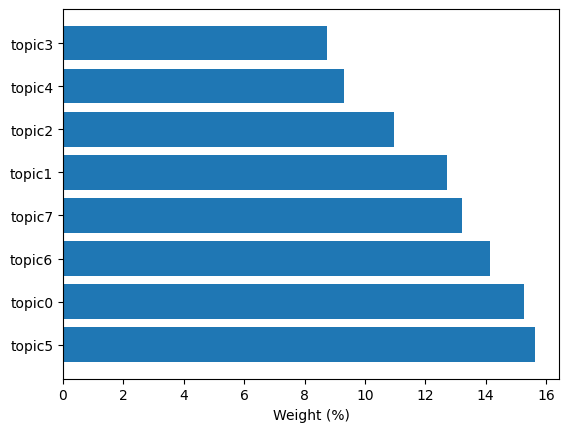

In [166]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(topics_mallet, distribution_df_mallet['weight'], align='center')
ax.set_xlabel('Weight (%)')

# Topics weight over time

## 4.1 Aggregate document weights

In [0]:
# The goal is to be able to group the data per month

In [0]:
import re

In [0]:
# function to retrieve date from file name
def get_date(file):
  date_match = re.findall(r'_(\d{4}-\d{2}-\d{2})_',file)
  return date_match[0]

# function to retrieve year from file name
def get_year(file):
  year_match = re.findall(r'_(\d{4})-\d{2}-\d{2}_',file)
  return year_match[0]

# function to retrieve month from file name
def get_month(file):
  month_match = re.findall(r'_\d{4}-(\d{2})-\d{2}_',file)
  return month_match[0]

In [0]:
distribution_gensim_wfiles['date'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_date(x))
distribution_gensim_wfiles['year'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_year(x))
distribution_gensim_wfiles['month'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_month(x))

In [0]:
gensim_groupby = distribution_gensim_wfiles.copy()

In [0]:
# drop columns that won't be needed at this stage
gensim_groupby = gensim_groupby.drop(['document_path', 'date'], axis=1)

In [0]:
# group by year and month 
distribution_month = gensim_groupby.groupby(['year','month']).sum().reset_index()

In [175]:
distribution_month

,year,month,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7
0,1903,04,0.014673,1.742224,0.000385,0.000341,1.813926,0.010221,0.000341,0.417888
1,1903,05,3.345623,2.106124,2.030354,0.631116,9.200397,3.333031,1.349021,4.004335
2,1903,06,1.420591,5.036722,5.720454,1.345795,5.649325,5.042119,4.349817,1.435178
3,1903,07,1.116823,2.164266,3.044721,0.391229,3.141787,13.188088,2.096852,5.856235
4,1903,08,0.877993,1.720331,1.249242,0.040626,0.132130,2.013672,2.611822,0.354184


In [0]:
dates = []
for i in range(len(distribution_month)):
  year = distribution_month['year'][i]
  month = distribution_month['month'][i]
  dates.append(f'{month}/{year}')

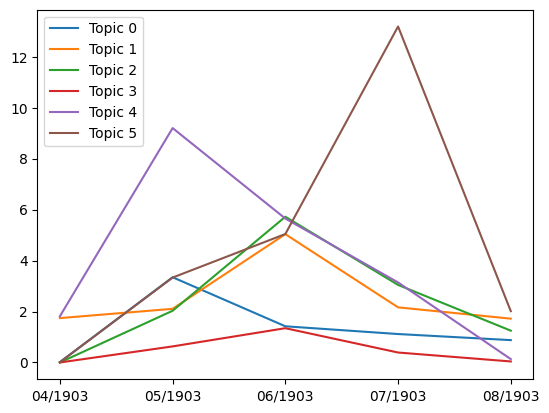

In [177]:
# quick first overview
plt.plot(dates, distribution_month['topic0'], label="Topic 0")
plt.plot(dates, distribution_month['topic1'], label="Topic 1")
plt.plot(dates, distribution_month['topic2'], label="Topic 2")
plt.plot(dates, distribution_month['topic3'], label="Topic 3")
plt.plot(dates, distribution_month['topic4'], label="Topic 4")
plt.plot(dates, distribution_month['topic5'], label="Topic 5")
plt.legend()